# Fraud Detection Analysis
### This notebook analyzes credit card transaction data to detect fraudulent activities.

## Import dependencies


In [103]:
# Import dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sqlalchemy import create_engine, inspect
import kagglehub
import os
import json
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score,
                           precision_score, recall_score, f1_score)

In [104]:

# Set plotting style
plt.style.use('bmh')
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=['#FF4B4B', '#4B4BFF', '#4BFF4B', '#FFB74B'])


## Database Connection and Data Loading

### Database Utility Functions


In [105]:
#  Load database configuration from JSON file
def load_db_config():
    try:
        with open('db_config.json', 'r') as file:
            return json.load(file)
    except FileNotFoundError:
        print("Error: db_config.json file not found!")
        print("Please create a db_config.json file with your database credentials.")
        raise

# Create PostgreSQL database connection
def create_db_engine():
    db_params = load_db_config()
    engine = create_engine(
        f"postgresql://{db_params['user']}:{db_params['password']}@"
        f"{db_params['host']}:{db_params['port']}/{db_params['database']}"
    )
    return engine

# Check if a table exists in the database
def table_exists(engine, table_name):
    inspector = inspect(engine)
    return table_name in inspector.get_table_names()

# Download data from Kaggle and load it into PostgreSQL
def load_data_to_postgres():
    # Define file paths
    fraud_test_csv = os.path.expanduser(
        r"~\.cache\kagglehub\datasets\kartik2112\fraud-detection\versions\1\fraudTest.csv")
    fraud_train_csv = os.path.expanduser(
        r"~\.cache\kagglehub\datasets\kartik2112\fraud-detection\versions\1\fraudTrain.csv")
    
    # Check if files already exist
    if not os.path.exists(fraud_test_csv) or not os.path.exists(fraud_train_csv):
        print("Downloading dataset from Kaggle...")
        kagglehub.dataset_download("kartik2112/fraud-detection")
    else:
        print("Dataset already exists. Skipping download.")

    # Create database engine
    engine = create_db_engine()
    
    # Check if tables exist in the database
    if table_exists(engine, 'fraud_train') and table_exists(engine, 'fraud_test'):
        print("Database tables already exist. Skipping data load.")
    else:
        print("Loading data into PostgreSQL...")
        # Read CSV files
        print("Reading CSV files...")
        fraud_test_df = pd.read_csv(fraud_test_csv)
        fraud_train_df = pd.read_csv(fraud_train_csv)
        
        print("Loading data into PostgreSQL tables...")
        fraud_train_df.to_sql('fraud_train', engine, if_exists='replace', index=False)
        fraud_test_df.to_sql('fraud_test', engine, if_exists='replace', index=False)
        print("Data successfully loaded to PostgreSQL!")


### Load necessary columns only

In [106]:
# Load fraud detection data from PostgreSQL
def load_fraud_data():
    engine = create_db_engine()
    
    # Query to load base columns
    query = """
        SELECT 
            amt, 
            trans_date_trans_time,
            is_fraud
        FROM fraud_train
    """
    
    query_test = """
        SELECT 
            amt, 
            trans_date_trans_time,
            is_fraud
        FROM fraud_test
    """
    
    fraud_train_df = pd.read_sql_query(query, engine)
    fraud_test_df = pd.read_sql_query(query_test, engine)
    
    return fraud_train_df, fraud_test_df

## Data Processing


In [107]:
# Extract time-based features from transaction datetime
def extract_time_features(df):
    df = df.copy()
    df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])
    
    # Extract time features if they don't exist
    if 'hour' not in df.columns:
        df['hour'] = df['trans_date_trans_time'].dt.hour
        df['day'] = df['trans_date_trans_time'].dt.day
        df['month'] = df['trans_date_trans_time'].dt.month
        df['day_of_week'] = df['trans_date_trans_time'].dt.dayofweek
        df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
        df['time_period'] = pd.cut(df['hour'], 
                                 bins=[-1, 6, 12, 18, 24], 
                                 labels=[0, 1, 2, 3])
        df['is_business_hours'] = df['hour'].between(9, 17).astype(int)
    
    return df

## Visualization Functions

In [108]:
# Plot fraud vs non-fraud distribution
def plot_fraud_distribution(df):
    plt.figure(figsize=(10, 5))
    fraud_counts = df['is_fraud'].value_counts()
    plt.bar(['Normal', 'Fraud'], fraud_counts.values)
    plt.title('Fraud vs. Non-Fraud Distribution')
    plt.ylabel('Number of Transactions')
    plt.show()

    fraud_percentage = (df['is_fraud'].sum() / len(df)) * 100
    print(f"Percentage of fraudulent transactions: {fraud_percentage:.2f}%")

# Visualize fraud patterns across different time features.
def plot_time_patterns(df):
    plt.figure(figsize=(15, 5))
    
    # Fraud by hour
    plt.subplot(1, 3, 1)
    fraud_by_hour = df[df['is_fraud'] == 1]['hour'].value_counts().sort_index()
    plt.bar(fraud_by_hour.index, fraud_by_hour.values)
    plt.title('Fraud Transactions by Hour')
    plt.xlabel('Hour of Day')
    plt.ylabel('Number of Fraudulent Transactions')
    
    # Fraud by day of week
    plt.subplot(1, 3, 2)
    fraud_by_dow = df[df['is_fraud'] == 1]['day_of_week'].value_counts().sort_index()
    plt.bar(fraud_by_dow.index, fraud_by_dow.values)
    plt.title('Fraud Transactions by Day of Week')
    plt.xlabel('Day of Week (0=Monday)')
    plt.ylabel('Number of Fraudulent Transactions')
    
    # Fraud by month
    plt.subplot(1, 3, 3)
    fraud_by_month = df[df['is_fraud'] == 1]['month'].value_counts().sort_index()
    plt.bar(fraud_by_month.index, fraud_by_month.values)
    plt.title('Fraud Transactions by Month')
    plt.xlabel('Month')
    plt.ylabel('Number of Fraudulent Transactions')
    
    plt.tight_layout()
    plt.show()

# Analyze and visualize transaction amounts.
def plot_amount_analysis(df):
    plt.figure(figsize=(15, 5))
    
    # Distribution of transaction amounts
    plt.subplot(1, 2, 1)
    plt.hist(df[df['is_fraud'] == 0]['amt'].values, 
             bins=50, alpha=0.5, label='Normal', density=True)
    plt.hist(df[df['is_fraud'] == 1]['amt'].values, 
             bins=50, alpha=0.5, label='Fraud', density=True)
    plt.title('Distribution of Transaction Amounts')
    plt.xlabel('Amount')
    plt.ylabel('Density')
    plt.legend()
    
    # Box plot of amounts
    plt.subplot(1, 2, 2)
    plt.boxplot([df[df['is_fraud'] == 0]['amt'], df[df['is_fraud'] == 1]['amt']], 
                labels=['Normal', 'Fraud'])
    plt.title('Transaction Amounts by Class')
    plt.ylabel('Amount')
    
    plt.tight_layout()
    plt.show()

## Model Development

In [109]:
# Create a preprocessing and modeling pipeline
def create_model_pipeline():
    numeric_features = ['amt', 'hour', 'day', 'month', 'day_of_week', 
                       'is_weekend', 'time_period', 'is_business_hours']
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numeric_features)
        ])
    
    return Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression(random_state=1))
    ])

# Evaluate model performance
def evaluate_model(y_true, y_pred, model_name="Model"):
    print(f"\n{model_name} Performance:")
    print("-" * 50)
    
    # Print confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    cm_df = pd.DataFrame(
        cm, 
        index=["Actual 0", "Actual 1"], 
        columns=["Predicted 0", "Predicted 1"]
    )
    print("\nConfusion Matrix:")
    print(cm_df)
    
    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))
    
    # Print ROC AUC score
    print("\nROC AUC Score:", roc_auc_score(y_true, y_pred))


## Plot feature importances/coefficients for all models side by side"

In [110]:
def plot_feature_importance(model, feature_names, model_name="Model"):
    if hasattr(model, 'feature_importances_'):
        importance = model.feature_importances_
        # Create feature importance dataframe
        feature_imp = pd.DataFrame({
            'Feature': feature_names,
            'Importance': importance
        }).sort_values('Importance', ascending=False)
        
        # Plot
        plt.figure(figsize=(10, 6))
        plt.bar(feature_imp['Feature'], feature_imp['Importance'])
        plt.xticks(rotation=45, ha='right')
        plt.title(f'{model_name} Feature Importance')
        plt.tight_layout()
        plt.show()

def plot_all_feature_importances(lr_model, rf_model, ada_model, feature_names):
    plt.figure(figsize=(15, 5))
    
    # Logistic Regression
    plt.subplot(1, 3, 1)
    coefficients = pd.Series(lr_model.coef_[0], index=feature_names).sort_values(ascending=True)
    coefficients.plot(kind='barh')
    plt.title('Logistic Regression\nFeature Coefficients')
    
    # Random Forest
    plt.subplot(1, 3, 2)
    rf_importance = pd.Series(rf_model.feature_importances_, index=feature_names).sort_values(ascending=True)
    rf_importance.plot(kind='barh')
    plt.title('Random Forest\nFeature Importance')
    
    # AdaBoost
    plt.subplot(1, 3, 3)
    ada_importance = pd.Series(ada_model.feature_importances_, index=feature_names).sort_values(ascending=True)
    ada_importance.plot(kind='barh')
    plt.title('AdaBoost\nFeature Importance')
    
    plt.tight_layout()
    plt.show()

## Main Analysis


Loading data for analysis...

Generating time features...

Generating data visualizations...


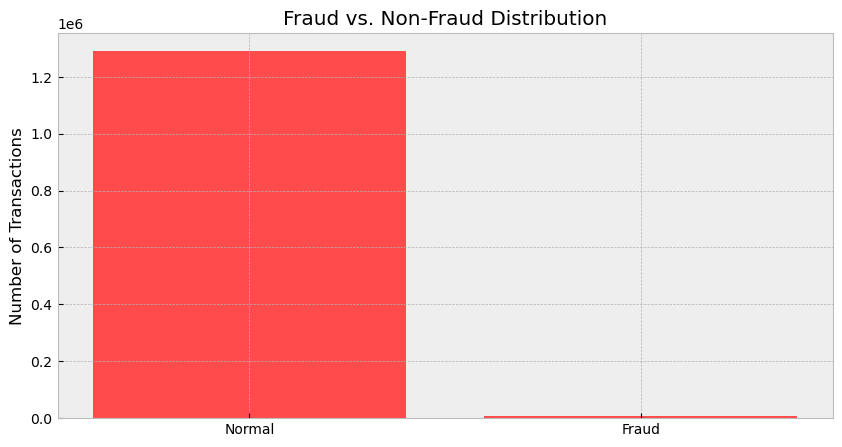

Percentage of fraudulent transactions: 0.58%


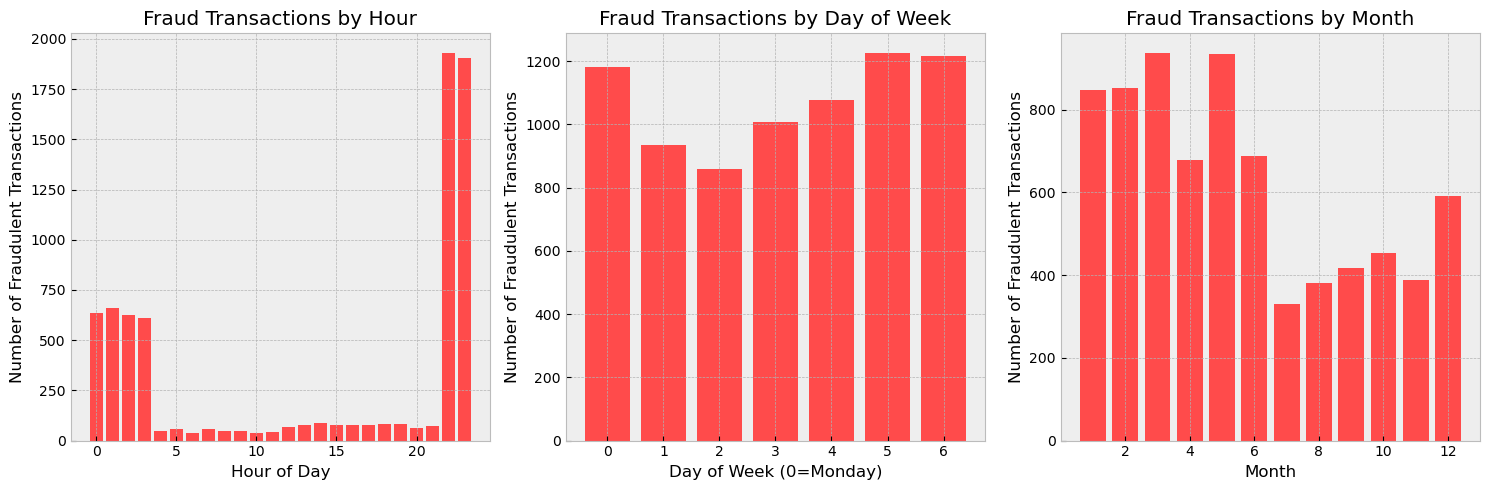

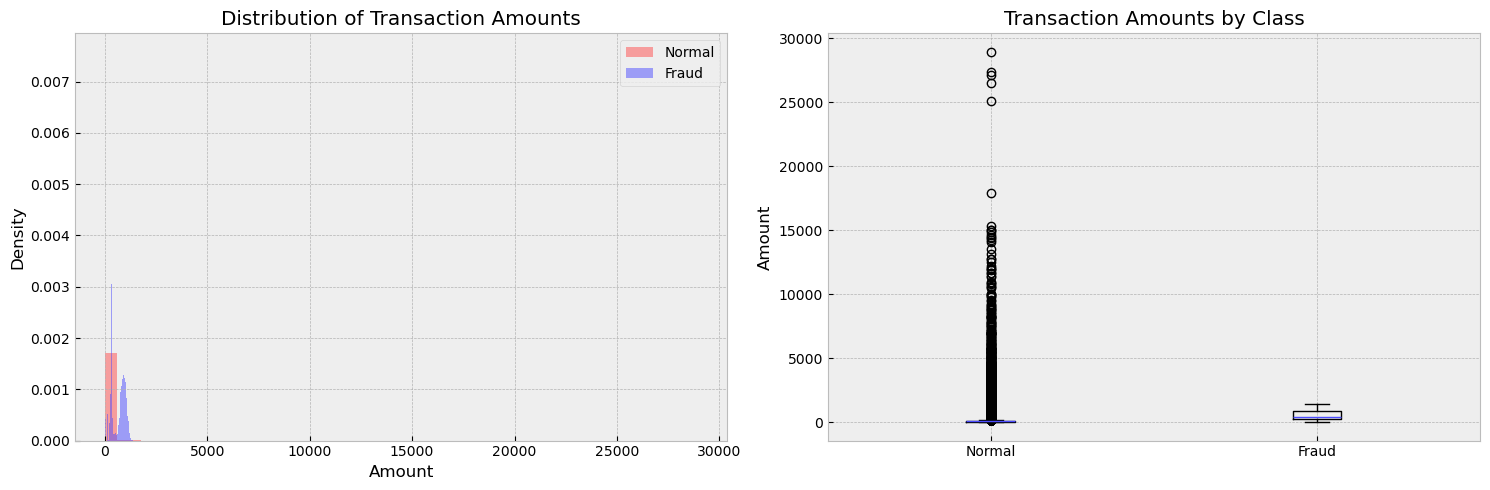


Preparing model data...

Training Logistic Regression...

Logistic Regression Performance:
--------------------------------------------------

Confusion Matrix:
          Predicted 0  Predicted 1
Actual 0       528889        24685
Actual 1          573         1572

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.96      0.98    553574
           1       0.06      0.73      0.11      2145

    accuracy                           0.95    555719
   macro avg       0.53      0.84      0.54    555719
weighted avg       1.00      0.95      0.97    555719


ROC AUC Score: 0.8441375409699429

Training Random Forest...

Random Forest Performance:
--------------------------------------------------

Confusion Matrix:
          Predicted 0  Predicted 1
Actual 0       553289          285
Actual 1         1439          706

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00     

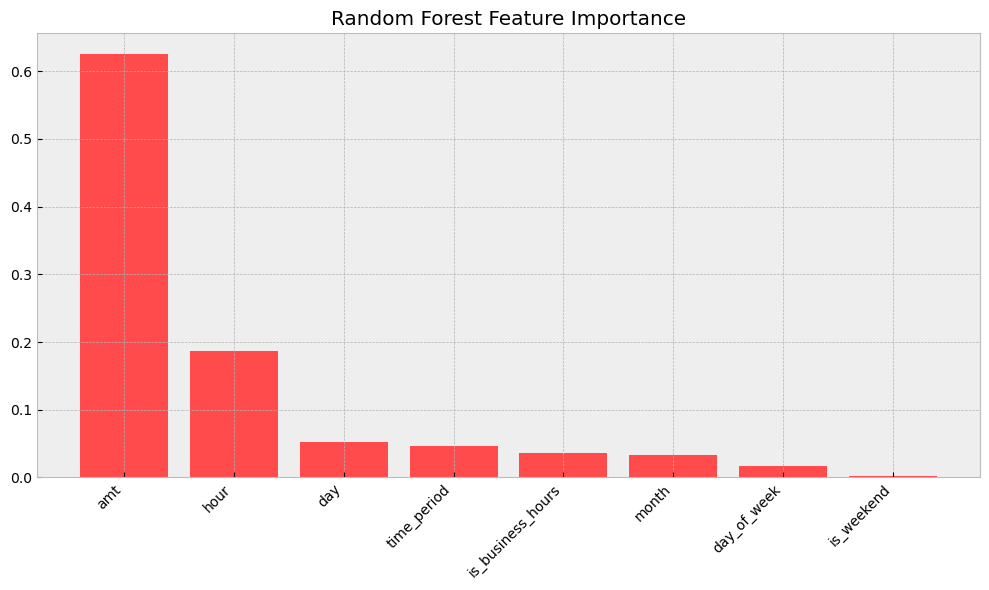


Training AdaBoost...

AdaBoost Performance:
--------------------------------------------------

Confusion Matrix:
          Predicted 0  Predicted 1
Actual 0       538384        15190
Actual 1          550         1595

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.99    553574
           1       0.10      0.74      0.17      2145

    accuracy                           0.97    555719
   macro avg       0.55      0.86      0.58    555719
weighted avg       1.00      0.97      0.98    555719


ROC AUC Score: 0.8580749355261886

Final Model Comparison

Logistic Regression:
  Accuracy:  0.9545
  Precision: 0.0599
  Recall:    0.7329
  F1 Score:  0.1107
  ROC AUC:   0.8441

Random Forest:
  Accuracy:  0.9969
  Precision: 0.7124
  Recall:    0.3291
  F1 Score:  0.4503
  ROC AUC:   0.6643

AdaBoost:
  Accuracy:  0.9717
  Precision: 0.0950
  Recall:    0.7436
  F1 Score:  0.1685
  ROC AUC:   0.8581


In [111]:
if __name__ == "__main__":
    # Load and prepare data
    print("\nLoading data for analysis...")
    train_df, test_df = load_fraud_data()
    
    print("\nGenerating time features...")
    train_df = extract_time_features(train_df)
    test_df = extract_time_features(test_df)
    
    # Exploratory Data Analysis
    print("\nGenerating data visualizations...")
    plot_fraud_distribution(train_df)
    plot_time_patterns(train_df)
    plot_amount_analysis(train_df)
    
    # Prepare features and target
    print("\nPreparing model data...")
    X_train = train_df.drop(['is_fraud', 'trans_date_trans_time'], axis=1)
    y_train = train_df['is_fraud']
    X_test = test_df.drop(['is_fraud', 'trans_date_trans_time'], axis=1)
    y_test = test_df['is_fraud']
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
    X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)
    
    # 1. Logistic Regression
    print("\n" + "="*50)
    print("Training Logistic Regression...")
    lr_model = LogisticRegression(class_weight='balanced', random_state=42)
    lr_model.fit(X_train_scaled, y_train)
    lr_pred = lr_model.predict(X_test_scaled)
    evaluate_model(y_test, lr_pred, "Logistic Regression")
    
    # 2. Random Forest
    print("\n" + "="*50)
    print("Training Random Forest...")
    rf_model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
    rf_model.fit(X_train_scaled, y_train)
    rf_pred = rf_model.predict(X_test_scaled)
    evaluate_model(y_test, rf_pred, "Random Forest")
    plot_feature_importance(rf_model, X_train.columns, "Random Forest")
    
    # 3. AdaBoost
    print("\n" + "="*50)
    print("Training AdaBoost...")
    base_estimator = DecisionTreeClassifier(max_depth=3, class_weight='balanced')
    ada_model = AdaBoostClassifier(
        estimator=base_estimator,
        n_estimators=50,
        learning_rate=1.0,
        random_state=42
    )
    ada_model.fit(X_train_scaled, y_train)
    ada_pred = ada_model.predict(X_test_scaled)
    evaluate_model(y_test, ada_pred, "AdaBoost")
    
    # Final comparison
    print("\n" + "="*50)
    print("Final Model Comparison")
    print("="*50)
    models = {
        'Logistic Regression': lr_pred,
        'Random Forest': rf_pred,
        'AdaBoost': ada_pred
    }
    
    for name, preds in models.items():
        accuracy = (preds == y_test).mean()
        precision = precision_score(y_test, preds)
        recall = recall_score(y_test, preds)
        f1 = f1_score(y_test, preds)
        auc = roc_auc_score(y_test, preds)
        
        print(f"\n{name}:")
        print(f"  Accuracy:  {accuracy:.4f}")
        print(f"  Precision: {precision:.4f}")
        print(f"  Recall:    {recall:.4f}")
        print(f"  F1 Score:  {f1:.4f}")
        print(f"  ROC AUC:   {auc:.4f}")